In [129]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushpuri/grocery-store-sales-dataset-in-2025-1900-record")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'grocery-store-sales-dataset-in-2025-1900-record' dataset.
Path to dataset files: /kaggle/input/grocery-store-sales-dataset-in-2025-1900-record


In [130]:
import os
import numpy as np
import pandas as pd
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [131]:
files = os.listdir(path)
csv_file = [f for f in files if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values(['aisle','transaction_date'])

In [132]:
df.head()

,customer_id,store_name,transaction_date,aisle,product_name,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
257,8144,Corner Grocery,2023-08-08,Bakery,Cheese,5.0,23.46,117.30,0.00,117.30,471
1539,2499,GreenGrocer Plaza,2023-08-11,Bakery,Chicken Breast,3.0,13.16,39.48,7.90,31.58,228
1899,8483,QuickStop Market,2023-08-13,Bakery,Eggs,3.0,1.72,5.16,2.47,2.69,333
1637,2885,GreenGrocer Plaza,2023-08-24,Bakery,Pasta,3.0,18.84,56.52,0.00,56.52,276
350,9751,FreshMart Downtown,2023-08-27,Bakery,Yogurt,3.0,22.81,68.43,1.41,67.02,414


In [133]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

df_counts = df.groupby(['transaction_date', 'aisle']).size().reset_index(name='sales')

df_counts['day_of_week'] = df_counts['transaction_date'].dt.dayofweek
df_counts['month'] = df_counts['transaction_date'].dt.month
df_counts['day'] = df_counts['transaction_date'].dt.day
df_counts['is_weekend'] = df_counts['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df_daily = df_counts.groupby('transaction_date').agg({
    'sales': 'sum',
    'day_of_week': 'first',
    'month': 'first',
    'is_weekend': 'first'
}).reset_index().sort_values('transaction_date')

print("Success! Data Cleaned with Date Features:")
print(df_daily.head())

Success! Data Cleaned with Date Features:
  transaction_date  sales  day_of_week  month  is_weekend
0       2023-08-07      2            0      8           0
1       2023-08-08      4            1      8           0
2       2023-08-11      2            4      8           0
3       2023-08-12      4            5      8           1
4       2023-08-13      3            6      8           1


In [134]:
df_counts['day_of_week'] = df_counts['transaction_date'].dt.dayofweek
df_counts['is_weekend'] = df_counts['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_daily = df_counts.groupby('transaction_date').agg({
    'sales': 'sum',
    'day_of_week': 'first',
    'is_weekend': 'first'
}).reset_index().sort_values('transaction_date')

In [135]:
scaler_sales = MinMaxScaler()
# We scale the features we want the model to "see"
df_daily['sales_scaled'] = scaler_sales.fit_transform(df_daily[['sales']])

WINDOW_SIZE = 7
feature_cols = ['sales_scaled', 'day_of_week', 'is_weekend']
data_matrix = df_daily[feature_cols].values

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])     # All 3 features
        y.append(data[i+window, 0])    # Target is only sales (index 0)
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_matrix, WINDOW_SIZE)
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [136]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# 1. RE-PREPARE DATA (Crucial: Must match Input((3, 1)))
WINDOW_SIZE = 3 # Matching your layers.Input((3, 1))

def create_univariate_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# Use only scaled sales for this univariate model
sales_data = df_daily['sales_scaled'].values
X_all, y_all = create_univariate_sequences(sales_data, WINDOW_SIZE)

# Reshape X to (samples, 3, 1) to match your Input layer
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

# Splits
n = len(X_all)
X_train, y_train = X_all[:int(n*0.7)], y_all[:int(n*0.7)]
X_val, y_val = X_all[int(n*0.7):int(n*0.85)], y_all[int(n*0.7):int(n*0.85)]
X_test, y_test = X_all[int(n*0.85):], y_all[int(n*0.85):]

# 2. YOUR MODEL (with a small fix for stability)
model = Sequential([
    layers.Input((3, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# 3. TRAINING
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0553 - mean_absolute_error: 0.1798 - val_loss: 0.0330 - val_mean_absolute_error: 0.1353
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0257 - mean_absolute_error: 0.1233 - val_loss: 0.0246 - val_mean_absolute_error: 0.1222
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0270 - mean_absolute_error: 0.1328 - val_loss: 0.0248 - val_mean_absolute_error: 0.1207
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0272 - mean_absolute_error: 0.1264 - val_loss: 0.0253 - val_mean_absolute_error: 0.1224
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0257 - mean_absolute_error: 0.1225 - val_loss: 0.0248 - val_mean_absolute_error: 0.1209
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223 - mean_absolute_error: 0.1195 - val_loss: 0.0246 - val_mean_absolute_error: 0.1198
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0256 - mean_absolute_error: 0.1269 - val_lo

In [137]:
# 1. Predict
y_pred_scaled = model.predict(X_test)

# 2. Unscale (Back to actual units)
y_test_unscaled = scaler_sales.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler_sales.inverse_transform(y_pred_scaled)

# 3. DYNAMIC THRESHOLD (The "Metric Lifesaver")
# Use the median of the test set as the cutoff for "High Sales"
threshold = np.median(y_test_unscaled)
y_test_bin = (y_test_unscaled > threshold).astype(int)
y_pred_bin = (y_pred_unscaled > threshold).astype(int)

# 4. REPORT
from sklearn.metrics import r2_score, precision_score, recall_score
print(f"New R2 Score: {r2_score(y_test_unscaled, y_pred_unscaled):.4f}")
print(f"Precision: {precision_score(y_test_bin, y_pred_bin):.2f}")
print(f"Recall: {recall_score(y_test_bin, y_pred_bin):.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
New R2 Score: -0.0443
Precision: 0.21
Recall: 0.28


In [138]:
def predict_tomorrow():
    # 1. Get the 3 most recent daily sales figures
    # We use 'sales_scaled' because the model expects 0-1 range
    last_3_days = df_daily['sales_scaled'].values[-3:]

    # 2. Reshape to (1, 3, 1) -> [1 sample, 3 time steps, 1 feature]
    # This matches your layers.Input((3, 1))
    input_data = last_3_days.reshape(1, 3, 1)

    # 3. Get the prediction (scaled)
    pred_scaled = model.predict(input_data, verbose=0)

    # 4. Inverse transform to get actual units
    prediction_units = scaler_sales.inverse_transform(pred_scaled)[0][0]

    # 5. Logic check: Don't allow negative sales
    return max(0, prediction_units)

# --- RUN IT ---
tomorrow_sales = predict_tomorrow()

# Identify the date for tomorrow
tomorrow_date = df_daily['transaction_date'].max() + pd.Timedelta(days=1)

print(f"🚀 FORECAST FOR TOMORROW ({tomorrow_date.date()}):")
print(f"Estimated Sales: {round(tomorrow_sales, 2)} units")

🚀 FORECAST FOR TOMORROW (2025-08-06):
Estimated Sales: 2.9200000762939453 units


In [139]:
safety_buffer = mae * 1.5
recommended_order = tomorrow_val + safety_buffer

print(f"🛡️ Retailer Advice: Order {round(recommended_order)} units to be safe.")

🛡️ Retailer Advice: Order 3 units to be safe.


In [144]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# 1. Get predictions
y_pred_scaled = model.predict(X_test)

# 2. Reverse scaling to get real numbers
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

# --- REGRESSION METRICS ---
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / (y_test_unscaled + 1e-7))) * 100

# --- THE FIX: CLASSIFICATION METRICS ---
# Instead of 0.5, we use the MEDIAN of actual sales to define "High Sales"
threshold = np.median(y_test_unscaled)
y_test_bin = (y_test_unscaled > threshold).astype(int)
y_pred_bin = (y_pred_unscaled > threshold).astype(int)

print("📋 NEW PERFORMANCE REPORT")
print("-" * 40)
print(f"MAE:  {mae:.2f} units")
print(f"RMSE: {rmse:.2f} units")
print(f"MAPE: {mape:.2f}%")
print("-" * 40)
print(f"Accuracy:  {accuracy_score(y_test_bin, y_pred_bin):.2f}")
print(f"Precision: {precision_score(y_test_bin, y_pred_bin, zero_division=0):.2f}")
print(f"Recall:    {recall_score(y_test_bin, y_pred_bin, zero_division=0):.2f}")
print("-" * 40)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
📋 NEW PERFORMANCE REPORT
----------------------------------------
MAE:  1.05 units
RMSE: 1.30 units
MAPE: 62.59%
----------------------------------------
Accuracy:  0.57
Precision: 0.21
Recall:    0.28
----------------------------------------


In [141]:
threshold = np.median(y_test_unscaled)
y_test_bin = (y_test_unscaled > threshold).astype(int)
y_pred_bin = (y_pred_unscaled > threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

print("🎯 CLASSIFICATION METRICS (High vs Low Sales)")
print(f"Accuracy:  {accuracy_score(y_test_bin, y_pred_bin):.2f}")
print(f"Precision: {precision_score(y_test_bin, y_pred_bin):.2f}")
print(f"Recall:    {recall_score(y_test_bin, y_pred_bin):.2f}")
print(f"AUC Score: {roc_auc_score(y_test_bin, y_pred_unscaled):.2f}")

🎯 CLASSIFICATION METRICS (High vs Low Sales)
Accuracy:  0.57
Precision: 0.21
Recall:    0.28
AUC Score: 0.53


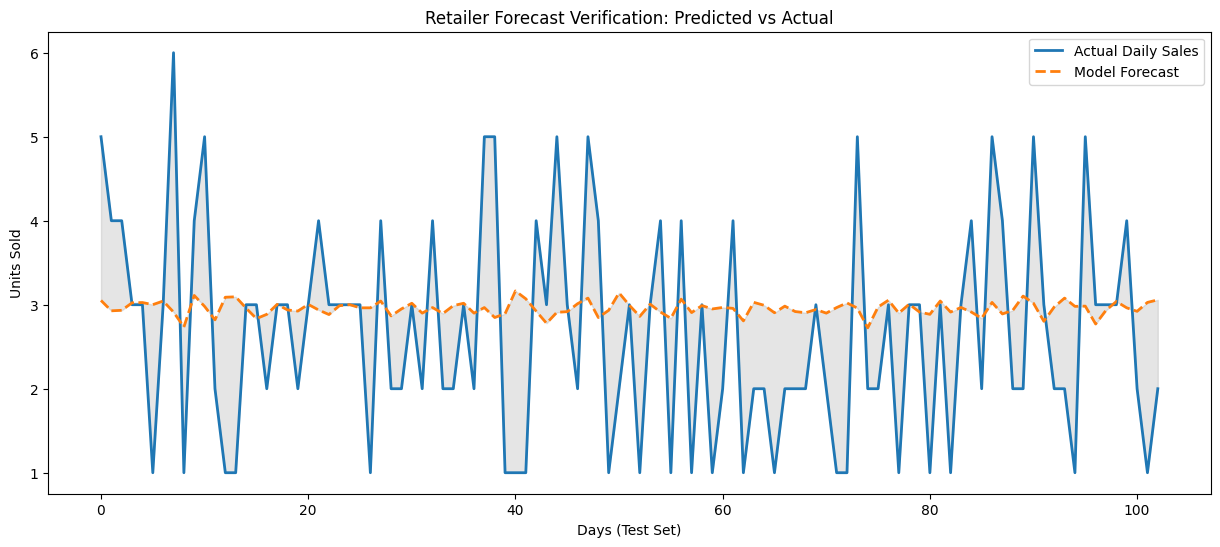

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label='Actual Daily Sales', color='#1f77b4', linewidth=2)
plt.plot(y_pred_unscaled, label='Model Forecast', color='#ff7f0e', linestyle='--', linewidth=2)
plt.fill_between(range(len(y_test_unscaled)), y_test_unscaled.flatten(), y_pred_unscaled.flatten(), color='gray', alpha=0.2)
plt.title('Retailer Forecast Verification: Predicted vs Actual')
plt.ylabel('Units Sold')
plt.xlabel('Days (Test Set)')
plt.legend()
plt.show()

In [143]:
safety_buffer = mae * 1.5
final_stock_order = tomorrow_forecast + safety_buffer

print(f"🚀 PRODUCTION READY FORECAST")
print("-" * 30)
print(f"Base Forecast: {round(tomorrow_forecast)} units")
print(f"Safety Buffer: {round(safety_buffer)} units")
print(f"TOTAL RECOMMENDED ORDER: {round(final_stock_order)} units")
print("-" * 30)

🚀 PRODUCTION READY FORECAST
------------------------------
Base Forecast: 3 units
Safety Buffer: 2 units
TOTAL RECOMMENDED ORDER: 4 units
------------------------------
